Let us show that velocity estimation based on slam-seq data gives more consistent and clean results. 
Note that this is irrespective of the velocity tools you will use. Original scSLAM-seq authors show that velocyto gives better results when using slam-seq data. Here I am using the same result with the recently improved scvelo package. Please come back to see the result with dynamo! 

In [1]:
import pandas as pd 
import numpy as np 

import scanpy as sc
import scvelo as scv

# data from Hendriks et al. 2018 

Let us first run velocity estimation based on splicing data

use wget to download the raw_data_loom_combined file and then load the loom data 

wget https://www.dropbox.com/s/a9ozcynpxudqdis/raw_data_loom_combined.loom?dl=1

here I just use data I have in my local directory

In [2]:
adata_MCMV = sc.read_loom('/home/xqiu/proj/dynamo/notebook_data/raw_data_loom_combined.loom')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
# add a treatment label to the adata_MCMV object
import re
batch = list()

for cell in adata_MCMV.obs.index.values:
    regex = re.compile('3LF70')
    result = regex.search(cell)
    if result is not None:
        label = 'mock'
    else:
        label = 'mcmv'
    batch.append(label)

# add it to the adata_MCMV object
adata_MCMV.obs['virus'] = np.array(batch)

In [4]:
adata_MCMV

AnnData object with n_obs × n_vars = 1146 × 56007 
    obs: 'virus'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Filtered out 39522 genes that are detected in less than 15 counts (spliced).
Filtered out 5172 genes that are detected in less than 10 counts (unspliced).
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:06.30) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on distances
    finished (0:00:00.04) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:00.02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:00.34) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


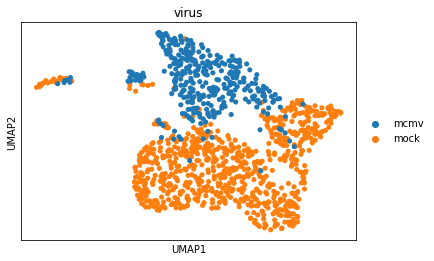

In [5]:
scv.pp.filter_and_normalize(adata_MCMV, min_counts=15, min_counts_u=10, n_top_genes=500) # n_top_genes can be tuned 
scv.pp.moments(adata_MCMV, n_pcs = 10, n_neighbors = 15, mode = 'distances') # 
scv.tl.velocity(adata_MCMV)
scv.tl.velocity_graph(adata_MCMV)

scv.tl.umap(adata_MCMV)
sc.pl.umap(adata_MCMV, color=['virus'])

computing velocity graph
    finished (0:00:00.33) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00.22) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


<Figure size 432x288 with 0 Axes>

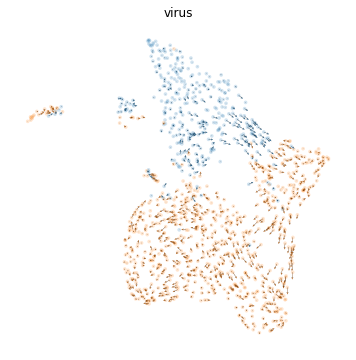

<Figure size 432x288 with 0 Axes>

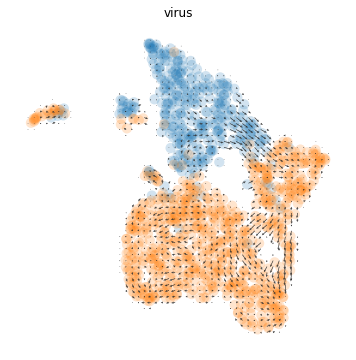

In [6]:
# scv.tl.umap(adata_slamseq)
scv.tl.velocity_graph(adata_MCMV)
scv.pl.velocity_embedding(adata_MCMV, color=['virus'], basis='umap', figsize=[6, 6])

scv.pl.velocity_embedding_grid(adata_MCMV, color=['virus'], basis='umap', figsize=[6, 6])


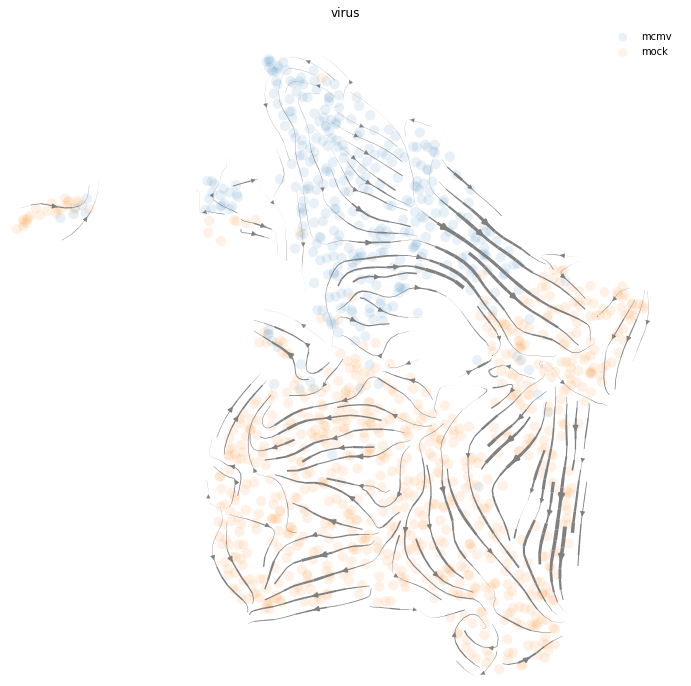

In [7]:
adata_MCMV_res = scv.pl.velocity_embedding_stream(adata_MCMV, color=['virus'], basis='umap', legend_loc=None, figsize=[12, 12], show=False, linewidth=2)
# intron_mcmv.figure.savefig('/home/xqiu/proj/dynamo/figures/intron_mcmv.svg') # save the figure 

The above velocity estimation results are kind messy. Next, let us try velocity estimation based on scSLAM-seq data. 

Note that we use total RNA (labelled new RNA + unlabeled old RNA) as **spliced** while the new RNA as **unspliced**

In [8]:
tot_RNA = pd.read_csv('https://www.dropbox.com/s/skgesrran9d48oy/emat_tot.txt?dl=1', index_col=0, delimiter='\s')
new_RNA = pd.read_csv('https://www.dropbox.com/s/kz0xj8hw4tbab9r/smat_new.txt?dl=1', index_col=0, delimiter='\s')

from anndata import AnnData
adata_sc_slamseq_MCMV = AnnData(tot_RNA.values.T,
    layers=dict(
        unspliced=new_RNA.values.T,
        spliced = tot_RNA.values.T)) 
adata_sc_slamseq_MCMV

# again, let annotate cells by virus infection
batch = list()

for cell in tot_RNA.columns.values:
    regex = re.compile('mock')
    result = regex.search(cell)
    if result is not None:
        label = 'mock'
    else:
        label = 'mcmv'
    batch.append(label)
    
# add it to the vlm object
adata_sc_slamseq_MCMV.obs['virus'] = np.array(batch)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [9]:
scv.pp.filter_and_normalize(adata_sc_slamseq_MCMV, min_counts=1, min_counts_u=1, n_top_genes=583)
scv.pp.moments(adata_sc_slamseq_MCMV, n_pcs = 10, n_neighbors = 15, mode = 'distances') # 
scv.tl.velocity(adata_sc_slamseq_MCMV)
scv.tl.velocity_graph(adata_sc_slamseq_MCMV)

Filtered out 19 genes that are detected in less than 1 counts (unspliced).
Skip filtering by dispersion since number of variables are less than `n_top_genes`
Logarithmized X.
computing neighbors
    finished (0:00:00.16) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on distances
    finished (0:00:00.00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:00.00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:00.03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00.03) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


<Figure size 432x288 with 0 Axes>

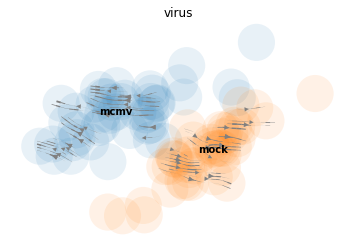

In [10]:
scv.pl.velocity_embedding_stream(adata_sc_slamseq_MCMV, color = ['virus'])


computing velocity embedding
    finished (0:00:00.04) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


<Figure size 432x288 with 0 Axes>

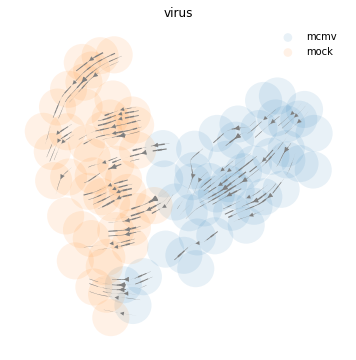

In [11]:
scv.tl.umap(adata_sc_slamseq_MCMV)

scv.pl.velocity_embedding_stream(adata_sc_slamseq_MCMV, basis='umap', color=['virus'], figsize=[6, 6], legend_loc=None)


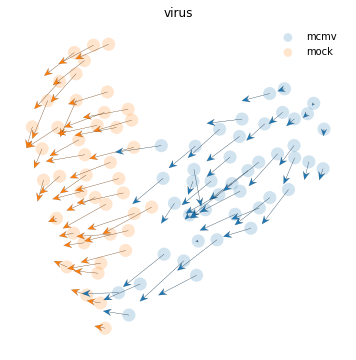

In [12]:
scv.pl.velocity_embedding(adata_sc_slamseq_MCMV, basis='umap', color=['virus'], figsize=[6, 6], arrow_size=4, arrow_length=5, legend_loc=None)


the velocity estimation here is much more apparent and consistent. let us save the result 

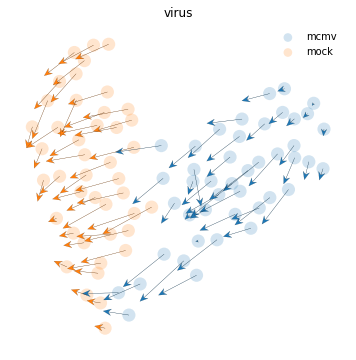

In [13]:
slamseq_mcmv = scv.pl.velocity_embedding(adata_sc_slamseq_MCMV, basis='umap', color=['virus'], figsize=[6, 6], arrow_size=4, arrow_length=5, legend_loc=None)

# slamseq_mcmv.figure.savefig('/home/xqiu/proj/dynamo/figures/slamseq_mcmv.svg')


# HL60 scSLAM-seq data by us 

In [14]:
expr_cnt = pd.read_csv('https://www.dropbox.com/s/5u6f48rohhfxt7a/190610_scslam.csv?dl=1', index_col=0)
sample_sheet = pd.read_csv('https://www.dropbox.com/s/cc93r5shm5ne873/2019-06-06_sample_sheet.csv?dl=1')
platemap_scSLAM = pd.read_csv('https://www.dropbox.com/s/qooq3hnigxsx9q2/384platemap_scSLAM.csv?dl=1', index_col=0)

In [15]:
expr_cnt.columns = expr_cnt.columns.str.split('_').str[0]

In [16]:
sample_sheet = sample_sheet.set_index(sample_sheet.Sample_ID.str.split('_').str[0])


In [17]:
print(expr_cnt.shape, sample_sheet.shape)

(26582, 351) (384, 16)


In [18]:
expr_cnt = expr_cnt.drop(['Undetermined'], axis=1)
expr_cnt = expr_cnt.drop(['__no_feature', '__ambiguous', '__too_low_aQual', 
                          '__not_aligned', '__alignment_not_unique'], axis=0)
expr_cnt.shape

(26577, 350)

In [19]:
sample_sheet = sample_sheet.loc[expr_cnt.columns, :]
sample_sheet['drug'] = sample_sheet.Sample_Name.str.split('_').str[0]
sample_sheet['cell_type'] = sample_sheet.Sample_Name.str.split('_').str[1]
sample_sheet['s4U'] = sample_sheet.Sample_Name.str.split('_').str[2]

sample_sheet.shape

(350, 19)

In [20]:
import anndata 
import scipy

In [21]:
print(expr_cnt.shape, sample_sheet.shape)
adata = anndata.AnnData(X=expr_cnt.T,obs = sample_sheet)

(26577, 350) (350, 19)


In [22]:
adata.obs = sample_sheet

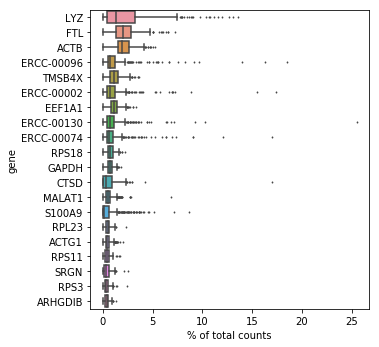

In [23]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [24]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=1)

In [25]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)


... storing 'Study_Description' as categorical
... storing 'BioSample_Description' as categorical
... storing 'Sample_Name' as categorical
... storing 'Sample_Owner' as categorical
... storing 'Organism' as categorical
... storing 'Tissue_Source' as categorical
... storing 'drug' as categorical
... storing 'cell_type' as categorical
... storing 's4U' as categorical


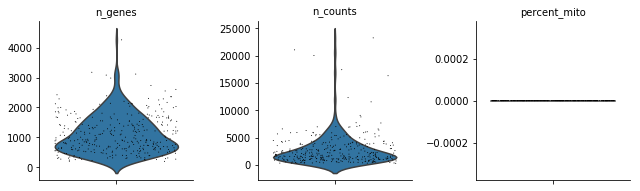

In [26]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

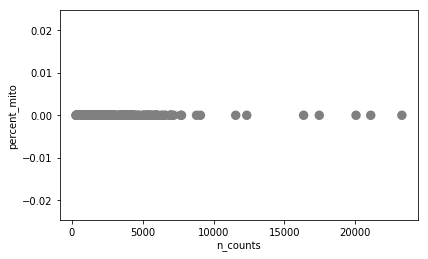

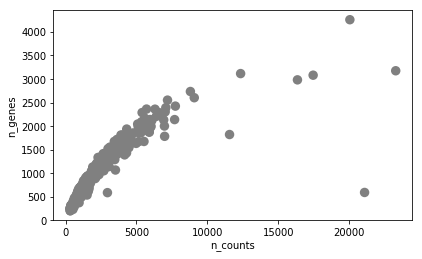

In [27]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [28]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)


In [29]:
sc.pp.log1p(adata)


In [30]:
adata.var['is_ERCC'] = adata.var.index.str.match('ERCC-')
adata = adata[:, ~ adata.var['is_ERCC']]
# ERCC_genes = adata.var_names.str.startswith('ERCC-')

# adata = adata[:, ~ERCC_genes]
# adata

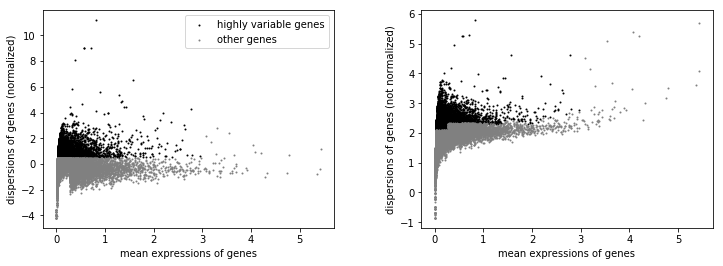

In [31]:

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)


In [32]:
adata = adata[:, adata.var['highly_variable']]


In [33]:
sc.pp.regress_out(adata, ['n_counts'])


In [34]:
sc.pp.scale(adata, max_value=10)


In [35]:
sc.tl.pca(adata, svd_solver='arpack')


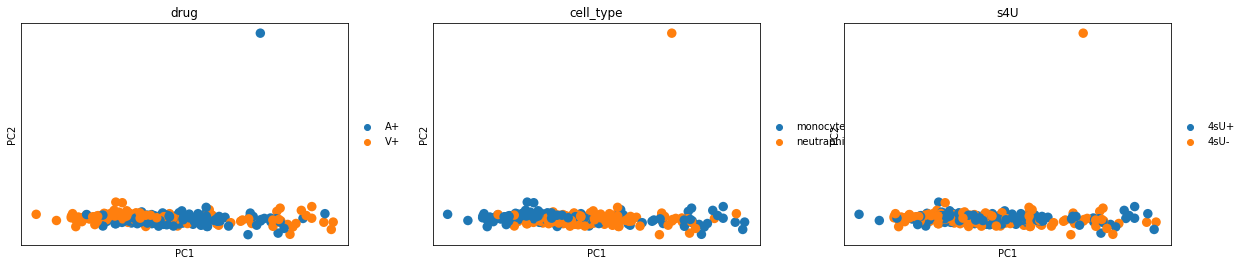

In [36]:
sc.pl.pca(adata, color=['drug', 'cell_type', 's4U'])


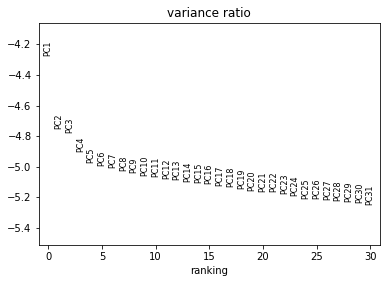

In [37]:
sc.pl.pca_variance_ratio(adata, log=True)


In [38]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)


In [39]:
sc.tl.umap(adata)

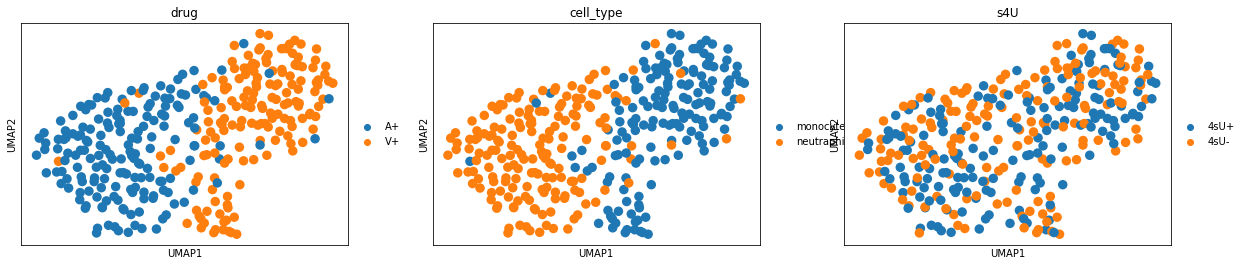

In [40]:
sc.pl.umap(adata, color = ['drug', 'cell_type', 's4U'])

So the above results show that even with very shollow sequencing (only 10 k reads / cell), we can distinguish cells treated with ATRA or VD3 well. 

we can calculate the absolute transcript counts with the linear regression model we discussed previously (Xiaojie Qiu, et. al, 2017). I am leaving it for now

```concentration = pd.read_table('ERCC_Controls_Analysis.txt', index_col=1)['concentration in Mix 1 (attomoles/ul)']```

```ercc_molecules = concentration * (9 * 1e-3 * 1./40000 * 1e-18 * 6.02214129 * 1e23)```

We will again first run velocity estimation with splicing-only data. 

use wget to download the raw_data_loom_combined file and then load the loom data 

wget https://www.dropbox.com/s/ng64dagia2p2bfy/onefilepercell_A10_scSLAM_S10_and_others_RSP38.loom?dl=1

here I just use data I have in my local directory

In [41]:
adata_loom = sc.read_loom('/home/xqiu/proj/dynamo/notebook_data/onefilepercell_A10_scSLAM_S10_and_others_RSP38.loom')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [42]:
well_id = adata_loom.obs.index.str.split(':').str[1].str.split('_').str[0]
adata_loom.obs = adata_loom.obs.set_index(well_id)

In [43]:
scv.pp.filter_and_normalize(adata_loom, min_counts=2, min_counts_u=1, n_top_genes=1500)
scv.pp.moments(adata_loom, n_pcs = 10, n_neighbors = 15, mode = 'distances') # 
scv.tl.velocity(adata_loom)
scv.tl.velocity_graph(adata_loom)


Filtered out 22623 genes that are detected in less than 2 counts (spliced).
Filtered out 3034 genes that are detected in less than 1 counts (unspliced).
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00.31) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on distances
    finished (0:00:00.01) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:00.02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:00.06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [44]:
adata_loom.obs = pd.concat([adata_loom.obs, sample_sheet.loc[well_id, :]], axis=1)

computing velocity embedding
    finished (0:00:00.03) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


<Figure size 432x288 with 0 Axes>

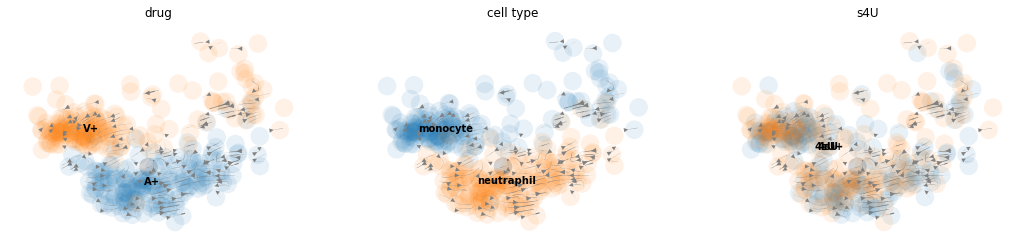

In [45]:
scv.pl.velocity_embedding_stream(adata_loom, color=['drug', 'cell_type', 's4U'])

We sequenced  172 4sU labelled cells

In [46]:
sum(adata_loom.obs['s4U'] == '4sU+')

172

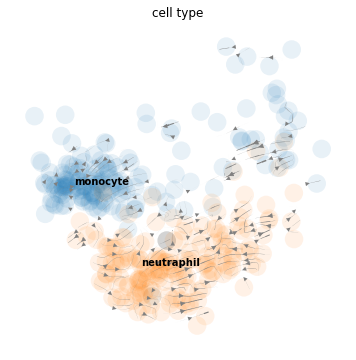

In [47]:
scv.pl.velocity_embedding_stream(adata_loom, color=['cell_type'], figsize=[6, 6])

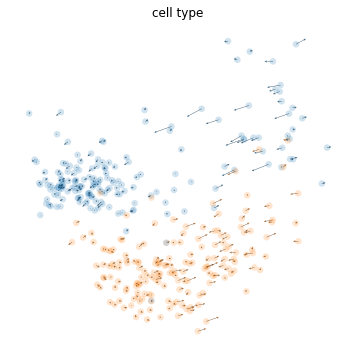

In [48]:
scv.pl.velocity_embedding(adata_loom, color=['cell_type'], figsize=[6, 6])

In [49]:
scv.pp.filter_genes(adata_loom, min_shared_counts=3)
scv.pp.normalize_per_cell(adata_loom)
scv.pp.filter_genes_dispersion(adata_loom, n_top_genes=3000)
scv.pp.log1p(adata_loom)

Filtered out 993 genes that are detected in less than 3 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`


In [50]:
scv.pp.filter_and_normalize(adata_loom, min_shared_counts=3, n_top_genes=3000)
scv.pp.moments(adata_loom, n_pcs=15, n_neighbors=15)

Skip filtering by dispersion since number of variables are less than `n_top_genes`
Did not modify X as it looks preprocessed already.
computing moments based on connectivities
    finished (0:00:00.01) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)


In [51]:
scv.tl.velocity(adata_loom)


computing velocities
    finished (0:00:00.00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [52]:
scv.tl.velocity_graph(adata_loom)


computing velocity graph
    finished (0:00:00.06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [53]:
scv.tl.umap(adata_loom)

computing velocity embedding
    finished (0:00:00.08) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


<Figure size 432x288 with 0 Axes>

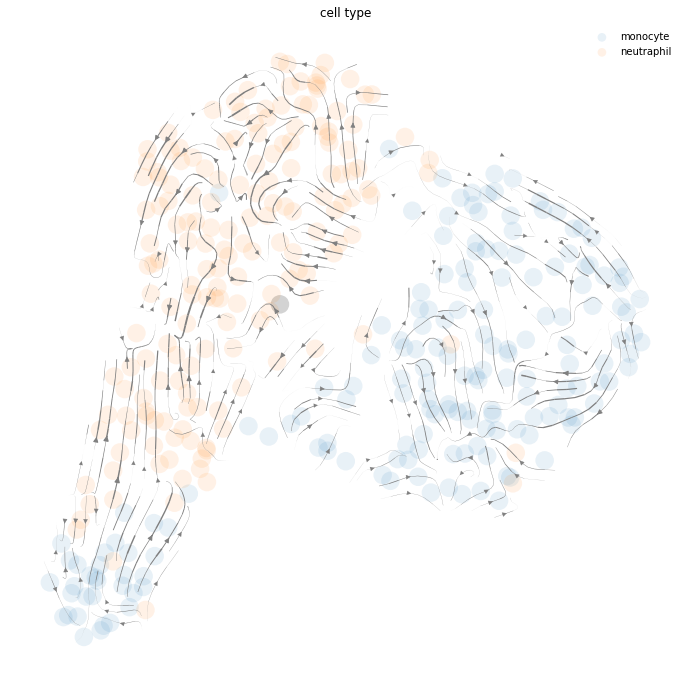

In [54]:
p1 = scv.pl.velocity_embedding_stream(adata_loom, basis='umap', color=['cell_type'], figsize=[12, 12], legend_loc = None, show = False)
# p1.figure.savefig('/home/xqiu/proj/dynamo/figures/HL60_splicing_data.svg')

<Figure size 432x288 with 0 Axes>

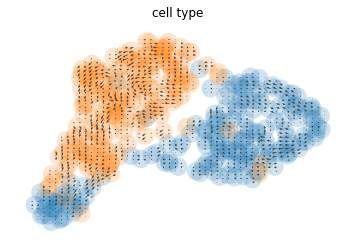

In [55]:
scv.pl.velocity_embedding_grid(adata_loom, basis='umap', color=['cell_type'])


# HL60 scSLAM-seq data

In [56]:
new_RNA = pd.read_csv('https://www.dropbox.com/s/kxej0h2p69ajf7l/slam_seq_newTable.csv?dl=1', index_col=0)
old_RNA = pd.read_csv('https://www.dropbox.com/s/3df72kg7drnid8t/slam_seq_oldTable.csv?dl=1', index_col=0)


In [57]:
# our sequencing is very shallow so a lot cells didn't pass filter to quantify mutation reads 
cellFilter = pd.read_csv('https://www.dropbox.com/s/w3p641o4afmc0k5/cellFilter.txt?dl=1', header=None)

In [58]:
filtered_cellName = cellFilter[0].str.split('_').str[1]

In [59]:
new_RNA.fillna(0, inplace=True)
old_RNA.fillna(0, inplace=True)
old_RNA.shape

(176, 58768)

In [60]:
from anndata import AnnData
adata_slamseq = AnnData(new_RNA.values + old_RNA.values,
    layers=dict(
        unspliced=new_RNA.values,
        spliced = old_RNA.values + new_RNA.values))
adata_slamseq

AnnData object with n_obs × n_vars = 176 × 58768 
    layers: 'unspliced', 'spliced'

In [61]:
adata_slamseq.obs = adata_slamseq.obs.set_index(new_RNA.index.str.split('_').str[1])
tmp = adata_loom.obs.loc[adata_slamseq.obs.index.values, :]

adata_slamseq.obs = pd.concat([adata_slamseq.obs, tmp.iloc[:, 4:]], axis=1)

In [62]:
adata_slamseq = adata_slamseq[filtered_cellName.values]

In [63]:
scv.utils.show_proportions(adata_slamseq)


Abundance of ['spliced', 'unspliced']: [0.86 0.14]


In [64]:
scv.utils.show_proportions(adata_loom)


Abundance of ['spliced', 'unspliced', 'ambiguous']: [0.93 0.04 0.03]


In [65]:
adata_slamseq = adata_slamseq[np.where([i is not np.nan for i in adata_slamseq.obs.Index.values])]

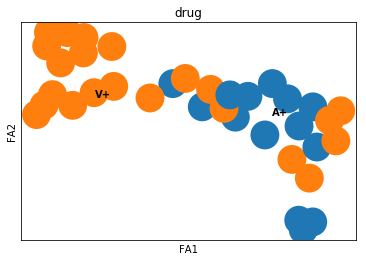

In [66]:
# sc.pp.recipe_zheng17(adata_slamseq) 
sc.tl.pca(adata_slamseq, svd_solver='arpack', n_comps=30)
sc.pp.neighbors(adata_slamseq, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata_slamseq)
sc.pl.draw_graph(adata_slamseq, color='drug', legend_loc='on data')


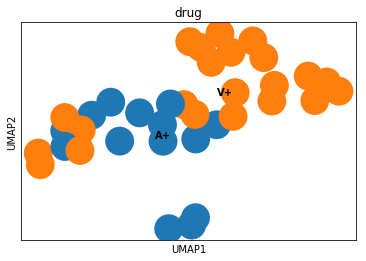

In [67]:
sc.tl.umap(adata_slamseq)
sc.pl.umap(adata_slamseq, color='drug', legend_loc='on data')


In [68]:
scv.tl.velocity(adata_slamseq)
scv.tl.velocity_graph(adata_slamseq)

Normalized count data: X, spliced, unspliced.
computing neighbors
    finished (0:00:00.03) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:00.03) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:00.23) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:00.00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [69]:
pos = [list(adata_loom.obs.Index.values).index(i) for i in adata_slamseq.obs.Index.values]
# adata_slamseq.obsm['X_umap'] = adata_loom.obsm['X_umap'][pos]

In [70]:
scv.pp.filter_and_normalize(adata_slamseq, min_counts=10, min_counts_u=1, n_top_genes=1000)
scv.pp.moments(adata_slamseq, n_pcs = 10, n_neighbors = 5, mode = 'connectivities') # 

scv.tl.velocity(adata_slamseq)
scv.tl.velocity_graph(adata_slamseq)

Filtered out 58617 genes that are detected in less than 10 counts (spliced).
Filtered out 42 genes that are detected in less than 1 counts (unspliced).
Skip filtering by dispersion since number of variables are less than `n_top_genes`
Logarithmized X.
computing moments based on connectivities
    finished (0:00:00.00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:00.00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:00.01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


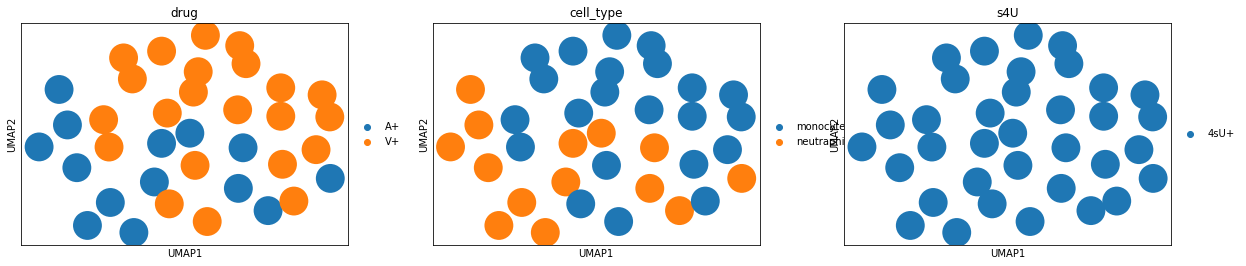

In [71]:
scv.tl.umap(adata_slamseq)
sc.pl.umap(adata_slamseq, color=['drug', 'cell_type', 's4U'])

computing velocity embedding
    finished (0:00:00.03) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


<Figure size 432x288 with 0 Axes>

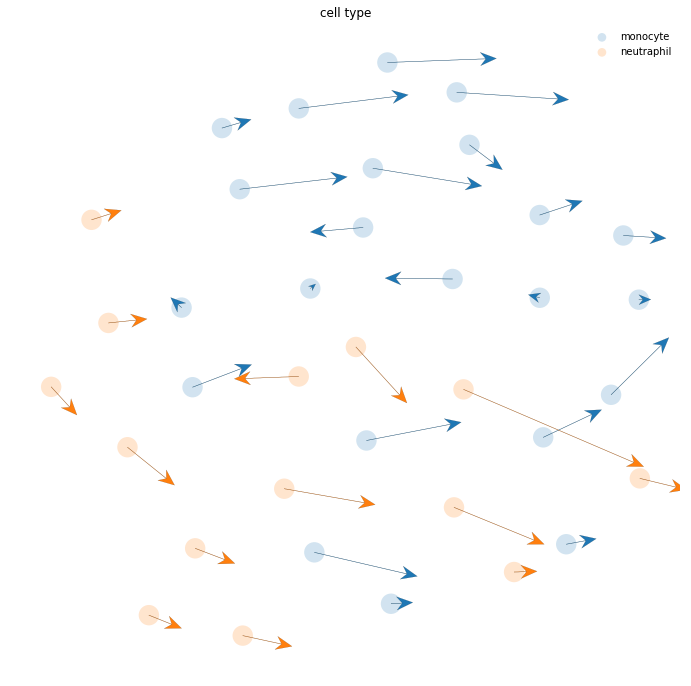

In [72]:
p2 = scv.pl.velocity_embedding(adata_slamseq, basis='umap', color=['cell_type'], figsize=[12, 12], 
                          arrow_size=4, arrow_length=5, legend_loc=None, show = False)
# p2.figure.savefig('/home/xqiu/proj/dynamo/figures/HL60_slam_seq.svg')

# HL60 scSLAM-seq read count data generated from mutation quantification pipeline 
this is a indirect demonstration of the quantification pipeline 

In [73]:
readCounts = pd.read_csv('https://www.dropbox.com/s/jmfftwogqanbw1i/readCounts.csv?dl=1', index_col=0)


In [74]:
adata_readCounts = anndata.AnnData(X=readCounts,obs = sample_sheet)

In [75]:
adata_readCounts.obs = adata_readCounts.obs.set_index(readCounts.index.str.split('_').str[1])


In [76]:
tmp = adata.obs.loc[adata_readCounts.obs.index.values, :]


In [77]:
adata_readCounts.obs = pd.concat([adata_readCounts.obs, tmp.iloc[:, 4:]], axis=1)

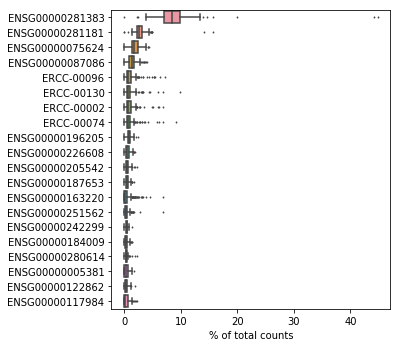

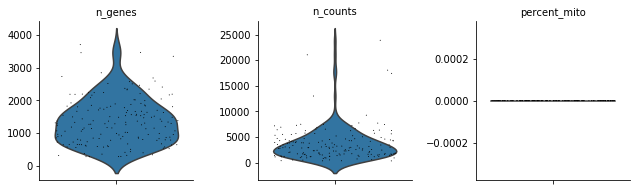

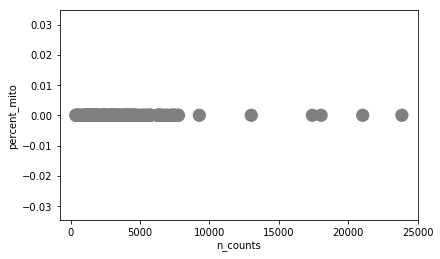

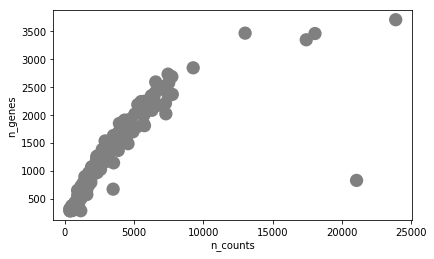

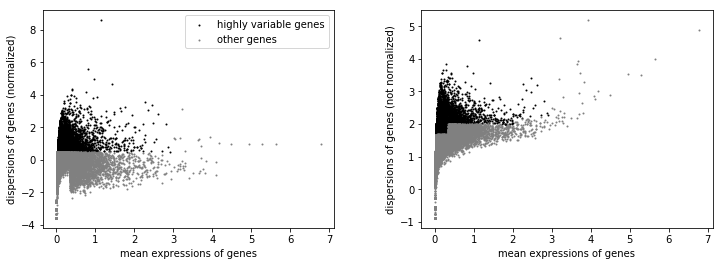

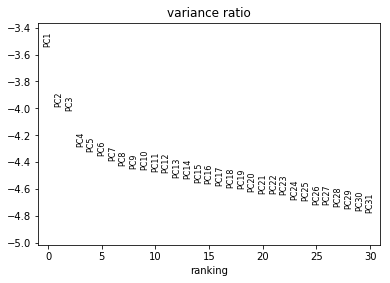

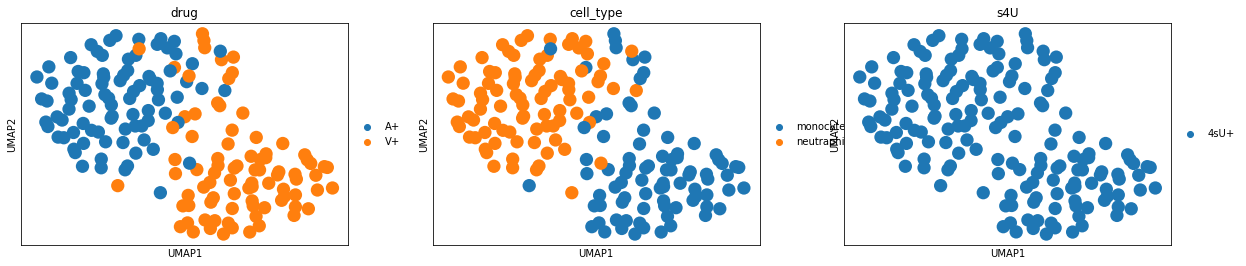

In [78]:
sc.pl.highest_expr_genes(adata_readCounts, n_top=20)
sc.pp.filter_cells(adata_readCounts, min_genes=200)
sc.pp.filter_genes(adata_readCounts, min_cells=1)
mito_genes = adata_readCounts.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata_readCounts.obs['percent_mito'] = np.sum(
    adata_readCounts[:, mito_genes].X, axis=1) / np.sum(adata_readCounts.X, axis=1)
# add the total counts per cell as observations-annotation to adata_readCounts
adata_readCounts.obs['n_counts'] = adata_readCounts.X.sum(axis=1)
sc.pl.violin(adata_readCounts, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)
sc.pl.scatter(adata_readCounts, x='n_counts', y='percent_mito')
sc.pl.scatter(adata_readCounts, x='n_counts', y='n_genes')
sc.pp.normalize_per_cell(adata_readCounts, counts_per_cell_after=1e4)
sc.pp.log1p(adata_readCounts)
adata_readCounts.var['is_ERCC'] = adata_readCounts.var.index.str.match('ERCC-')
adata_readCounts = adata_readCounts[:, ~ adata_readCounts.var['is_ERCC']]
sc.pp.highly_variable_genes(adata_readCounts, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata_readCounts)
adata_readCounts = adata_readCounts[:, adata_readCounts.var['highly_variable']]
sc.pp.regress_out(adata_readCounts, ['n_counts'])
sc.pp.scale(adata_readCounts, max_value=10)
sc.tl.pca(adata_readCounts, svd_solver='arpack')
sc.tl.pca(adata_readCounts, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_readCounts, log=True)
sc.pp.neighbors(adata_readCounts, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata_readCounts)
sc.pl.umap(adata_readCounts, color = ['drug', 'cell_type', 's4U'])
